In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.optim as optim
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import weights_init, cuda2numpy, do_test_VAE, image_from_output, image_from_numpy, colors
from dataset import transform, Dataset_MNIST
from model import VAE

In [3]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# References
- [Auto-Encoder: What Is It? And What Is It Used For? (Part 1)](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)
- [Understanding Latent Space in Machine Learning](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d)
- [Understanding Variatinal Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [Convolutional autoencoder for image denoising](https://keras.io/examples/vision/autoencoder/)
- [A Survey on Variational Autoencoders from a Green AI Perspactive](https://link.springer.com/article/10.1007/s42979-021-00702-9)

# Introduction
---
この授業ではオートエンコーダの理論と実装を学びます．
この授業は以下の7つのセクションに分かれています．

- オートエンコーダの直感的な理解
- 利点
- オートエンコーダ(Auto-Encoder)とは
- Variational Auto-Encoderとは
- 実装と演習
- 応用例
- 最近の研究

---

In this lesson, you will learn the theory and the implementation of Auto-Encoders.
The lesson is devided into 7 sections.

- Brief Introduction of Auto-Encoder
- Motivation
- How Auto-Encoder (AE) works
- How Variational Auto-Encoder (VAE) works
- Implementation and Exercise
- Applications
- Recent Research

---

# Brief Introduction of Auto-Encoder
---
オートエンコーダは教師なし機械学習の一つで，データの圧縮(Encoding)とデータの展開(Decoding)を学習するモデルであり，表現学習(representation learning)の一つです．
圧縮を担当するEncoderと展開を担当するDecoderの二つのモデルで構成されています．
以下のような流れで処理していきます．

<img src="./../data/images/auto-encoder_flowchart.png" width="900">

ここで圧縮されたベクトルを"潜在ベクトル(latent code)"と呼びます．
ある程度AEによる再構築が成功すると，この潜在ベクトルに入力データの重要な情報が圧縮されていると考えることができます(MNISTデータであれば，元のデータの次元数は28\*28=784で，例では10次元に圧縮されている)．
このように一度Encoderで圧縮して，Decoderで展開するモデルをオートエンコーダ(Auto-Encoder)という．

---

Auto-Encoder (AE) is one of *un*supervised machine learning model that learns the representation of data.
It has two models, Encoder and Decoder, and they are in charge of data compression and data expantion, respectively.
The figure below illustrates the process of basic AE.

<img src="./../data/images/auto-encoder_flowchart.png" width="900">

The compressed data is called *latent code* and when AE successfully reconstruct the input data, it can mean that the important information is compressed in the latent code (in case of MNIST, the dimension of original data is 28\*28=784, which is compressed to 10-dimension).
In summary, the model that compress and expand data is called Auto-Encoder.
---

# Motivation
---
オートエンコーダを用いる利点は，大きく分けて二つあります．
- データの圧縮 

まず一つ目は，データの圧縮です．
先ほどの例では784次元を10次元で表すことができ，データの圧縮ができています．
これにより，モデルの軽量化や高速化，重要な特徴に集中など様々な利点が期待できます．
なので，Encoderは特徴量抽出器としても用いられていると考えることができます．

- 入力データの概要

そして次に入力データの概要をDecoderが出力できる点です．
Decoderの入力としては，圧縮された潜在ベクトルしかないので，入力データの重要な部分のみを出力すると考えることができます．
主な例ではノイズ軽減があります．

今回の授業では，一つ目のデータの圧縮の部分にフォーカスを当てたいと思っています．

---

---

# How Auto-Encoder(AE) works
---
オートエンコーダは以下の図のように，大きく分けて4つの重要な部分に分かれています．
- エンコーダ, Encoder(黄色): このモデルは入力データの効率的な圧縮方法を学習します．
- ボトルネック, Bottle neck(赤色): 入力データが処理されていき，最も次元数が小さくなる部分
- デコーダ, Decoder(オレンジ色): このモデルは潜在ベクトルの効率的な展開方法を学習します．
- 再構築損失, Reconstruction Loss(青色): これがオートエンコーダの損失であり，入力データと出力データの違いを値とします．この値が小さくなるようにオートエンコーダは学習します．

<img src="./../data/images/AE.png" width="900">

オートエンコーダ(EncoderとDecoder)の構造としては様々な種類があるが，今授業では全結合層で構成されたオートエンコーダを実装します．
EncoderとDecoderではいきなり圧縮(展開)するのではなく，層が深くなるごとに徐々に圧縮(展開)していきます．
この時入力データが画像などの2次元データの場合は，まず一次元化(Flatten)してからEncoderに入力します(28x28 -> 1x784)．
再構築損失は平均二乗誤差(Mean Squared Error, MSE)を用いるのが一般的です．
$$
\text{MSE} = \frac{1}{n} \sum^n_{i=1} (\hat{y}_i - y_i)^2
$$

---
There are four major features of Auto-Encoder:
- Encoder (Yellow): The model that learns an effective way to compress input data.
- Bottle Neck (Red): The part where the input data is most compressed.
- Decoder (Orange): The model that learns an effective way to compress input data.
- Reconstruction Loss (Blue): This is the loss for VAE and it indicates the difference of the input and the output data. AE learns to minimize this loss.

<img src="./../data/images/AE.png" width="900">

In this lesson, we will implement the Auto-Encoder with the simplest structure, which is consists of few fully connected layers.
In deeplearning, Encoder and Decoder process input data gradually as the layers become deeper.
If the input data is 2D data such as an image, it is first flattened to one dimension (28x28 -> 1x784) before being input to the encoder.
The reconstruction loss is usually computed using Mean Squared Error (MSE).

$$
\text{MSE} = \frac{1}{n} \sum^n_{i=1} (\hat{y}_i - y_i)^2
$$

---

# How Variational Auto Encoder (VAE) works
---
オートエンコーダは様々な方向に応用されてきました．
その中でも一番有名なのが，Variational Auto-Encoder (VAE)です．
これは，再構築損失に加え，潜在ベクトルの分布をガウス分布に近づける損失(KL Loss)も加わります．
これによりVAEは通常のAEに比べ，以下の二つの利点が生まれました．
- 過学習(over-fitting)を防ぐ
- 潜在ベクトルをより効率的に生成する

二つ目の効率的な生成は，VAEの潜在ベクトルは，通常のAEに比べて以下の二つの特徴が保証されていることが理由と考えられます．
- 連続性(Continuity): 潜在ベクトルにおける微小の変化すれば，出力データも微小に変化する性質
- 完全性(Completeness): 意味のないデータを出力しないこと

通常のAEの場合，潜在ベクトルに関して何も制限がなく，入力データに似たデータを出力することのみがタスクでした．
しかしそれにより，潜在空間の微小の変化に対して，出力が大きく変わってしまったり，意味のわからないデータを出力してしまうことがあります．
以下にその例を示します．

<img src="./../data/images/why_VAE.png" width="900">

VAEで，潜在ベクトルの分布も制御することに成功すれば，以下のような潜在空間を実現することができる．

<img src="./../data/images/ideal_latent_space.png" width="700">

これがVAEであり，この授業ではVAEの実装を行い，実際に　MNISTデータセットに対する挙動を確認する．

---

Autoencoders have been applied in various directions.
Among these, the most famous one is the Variational Auto-Encoder (VAE).
In addition to the reconstruction loss, VAE adds a loss that makes the distribution of latent vectors closer to a Gaussian distribution (KL Loss).
This gives VAE the following two advantages over ordinary AE.
- Prevent over-fitting
- Generate the latent vector more efficiently

The importance of the second reason lies in that the latent vectors of VAE are guaranteed to have the following two characteristics compared to those of ordinary AE.
- Continuity: A small change in a latent vector results in a small change in the output data.
- Completeness: Do not output meaningless data.

In the case of ordinary AE, there are no restrictions on the latent vectors, and the only task is to output data similar to the input data.
However, this can lead to large changes in the output for small changes in the latent space, or to output nonintuitive data.
The following are some examples.

<img src="./../data/images/why_VAE.png" width="900">

If we succeed in controlling the distribution of the latent vectors in VAE as well, we can realize the following latent space

<img src="./../data/images/ideal_latent_space.png" width="700">

This is VAE, and in this class, we will implement VAE and check its behavior on MNIST dataset.

---

# Implementation and Exercise
---
では実装してみましょう．
ノートブックをシンプルにするために、あまり関係しない関数の説明は省略します。
もし興味があれば、`VAE_lesson/pyfiles/`を見てみてください。
この実験では[このデータセット](https://drive.google.com/drive/folders/1FVkhfpMpGe1SZ22HsCfvjSO9WUi7tcBC?usp=sharing)を用いるので、
この先に進む前に`VAE_lesson/dataset/MNIST/`に入れておいてください。

---
Let's implement VAE.
To keep the notebook simple, we will skip explanations of functions that are not relevant.
If interested, please go to `VAE_lesson/pyfiles/`.
In this experiment, we will use [this dataset](https://drive.google.com/drive/folders/1FVkhfpMpGe1SZ22HsCfvjSO9WUi7tcBC?usp=sharing), so please put it in`VAE_lesson/dataset/MNIST/` before proceeding.

---

## Preparation
### Dataset
---
今回用いるデータセットは、[MNIST dataset](https://www.kaggle.com/oddrationale/mnist-in-csv)を実験用に改変したものです。
データセットは１０このクラスがあり、元の画像サイズは28x28で、色のチャネルは1つです。
それぞれのデータは、16x16にリサイズした後、最小値と最大値が-1と1になるように正規化されています。
[このデータセット](https://drive.google.com/drive/folders/1FVkhfpMpGe1SZ22HsCfvjSO9WUi7tcBC?usp=sharing)を`VAE_lesson/dataset/MNIST/`に入れておいてください。
以下がデータセットのサンプルになります．

---

The dataset we will use is a modified version of the MNIST dataset.
The dataset has 10 classes, the original image size is 28x28, and there is one color channel.
Each data has been resized to 16x16 and then normalized so that the minimum and maximum values become -1 and 1, respectively.
Again, please keep this dataset in `VAE_lesson/dataset/MNIST/`.
The following is a sample of the dataset.

---

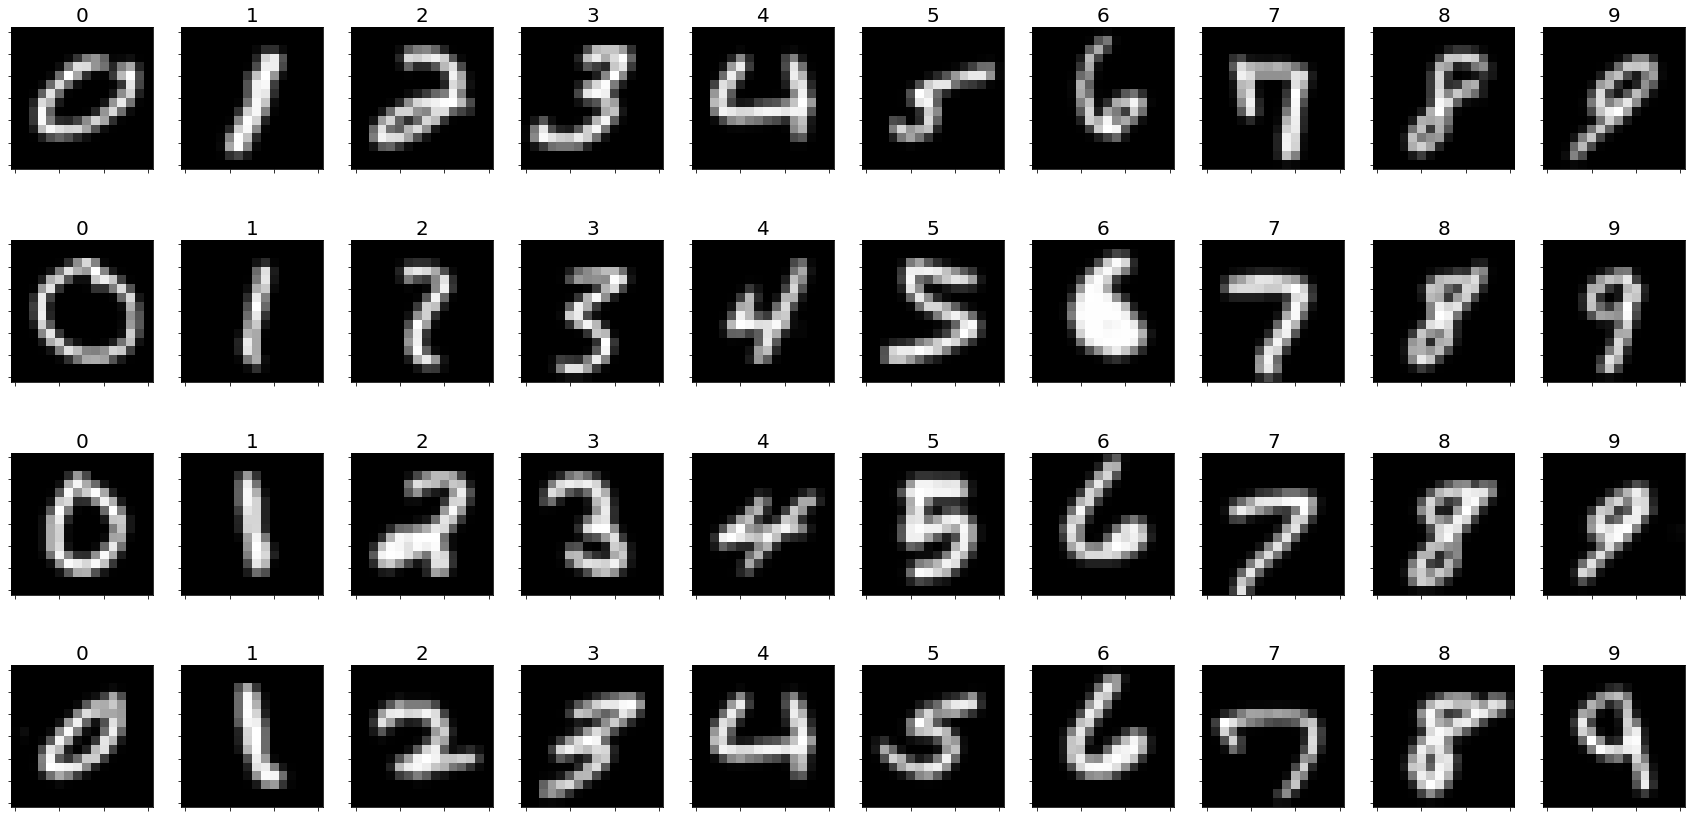

In [4]:
root = "../dataset/MNIST/"
classes = tuple(range(10))

dataset = Dataset_MNIST(root, classes, "train", transform["train"])
display_num = 4
each_num = int(len(dataset)/len(classes))
fig = plt.figure(figsize=(30, 15))
for i in range(display_num):
    for cl in classes:
        ax = fig.add_subplot(display_num, len(classes), len(classes)*i+cl+1)
        index = np.random.randint(0,each_num)+cl*each_num
        x, label = dataset[index]
        ax.imshow(image_from_output(x)[0])
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title(f"{cl}", fontsize=20)

### Model
---
今回の授業では，CPUでも実行できるように，シンプルな構造のモデルを用います．
畳み込み層は用いず，全結合層だけを用いています．
ハイパーパラメタとして，以下の3つが考えられます．
- *bfeatures*: 隠れ層(hidden layer)の特徴量数を表すパラメタ，大きいほどモデルの複雑度が増す．
- *n_layers*: エンコーダとデコーダの層の深さを決定するパラメタ
- *z_dim*: 潜在ベクトル(latent code)の次元数を決定するパラメタ

---
In this class, we will use a model with a simple structure so that it can be run on CPUs.
We do not use a convolutional layer, but only fully connected layers.
The following three hyperparameters are adjustable.
- *bfeatures*: A parameter that represents the number of features in the hidden layer.
- *n_layers*: A parameter that determines the depth of the encoder and decoder layers.
- *z_dim*: A parameter that determines the dimension of latent codes.

---

In [5]:
# ----- adjustable parameters ----- #
bfeatures = 16
n_layers = 3
z_dim = 3
# --------------------------------- #

# device = "cpu"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
torch.randn(3, 2, device="cuda:0")

In [ ]:
net = VAE(z_dim=z_dim, nch_input=1, nch=bfeatures, device=device, image_shape=(16, 16), n_layers=n_layers).to(device)
net.apply(weights_init);

### Training
---
そして，最適化関数とスケジューラは以下のを用いました。
- optimizer: Adam optimizer, デフォルトのパラメタ
- scheduler: 学習率が指数関数的に減少するスケジューラ

---
Some algorithms are employed: optimization and scheduler.
- optimizer: Adam optimizer with default parameters
- scheduler: learning rate scheduler which lowers the lr exponentially

---

In [10]:
# ----- adjustable parameters ----- #
lr = 0.001 # learning rate
epoch_num = 501 # the number of epochs
# --------------------------------- #

save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
fixed_image = dataset[100][0].unsqueeze(0)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
データセットを呼び出しましょう。`Dataloader`とはデータをバッチサイズにまとめてくれて、必要であればシャッフルしてくれます。

- *numbers*: データセットに含める数字（クラス）のリスト

---
Let's call the dataset. `Dataloader` is the function that will group the data into batch sizes and shuffle them if necessary.

- *numbers*: List of numbers (classes) to include in the dataset.

---

In [11]:
# ----- adjustable parameters ----- #
train_batch = 32
val_batch = 32
each_datanum = 300
numbers = (1, 7, 8, 3)
# --------------------------------- #

dataset = Dataset_MNIST(root, numbers, "train", transform["train"], each_datanum=each_datanum)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=False)
len(dataset), len(valset)

(840, 180)

## Training
---
では、訓練してみましょう。
このセルにはエポックごとのロスと，訓練サンプルと検証サンプルの再構成結果を出すようにしてます。
そして、検証用データにおいての一番いいエポックを記憶するようにしているので、後に呼び出してみましょう。

---
Now, let's train your model.
In this cell, we have the losses per epoch and the reconstruction results of the training and validation samples.
It also remembers the best epoch in the validation data, so let's recall it later.

---

In [12]:
train = False

if train:
    losses_epoch = []
    losses_epoch_test = []
    best_epoch = 0
    best_loss = np.inf
    for epoch in range(epoch_num):
        losses = []
        for itr, data in enumerate(dataloader):
            net.train()
            x = data[0].to(device)
            label = data[1].to(device)
            optimizer.zero_grad()
            _, _, loss = net(x, True)
            loss.backward()
            optimizer.step()

            loss = loss.to("cpu").detach().numpy()
            label = label.to("cpu").detach().numpy()
            losses.append(loss)
        losses_epoch.append(np.mean(np.array(losses)))
        scheduler.step()
        if epoch%test_interval==0:
            labels, inputs, outputs, loss_test, latents = do_test_VAE(net, valloader, device, "eval")
            losses_epoch_test.append(loss_test)
            if best_loss > loss_test:
                best_loss = loss_test
                best_epoch = epoch

        clear_output(wait=True)
        print(epoch)
        print(f"test loss in {epoch//test_interval*test_interval} : {loss_test}")
        print(f"best loss is   : {best_loss} in epoch{best_epoch}")
        if save_parameter:
            if epoch%test_interval==0:
                torch.save(net.state_dict(), 
                           f"../instant_parameters/VAE_MNIST_ndim{z_dim}_nch{bfeatures}_lr{lr}_epoch{epoch}.pth")

        width = 3
        val_num = 2
        height = 1 + val_num

        fig = plt.figure(figsize=(5*width,5*height))
        ax = fig.add_subplot(height,width,1)
        ax.plot(losses_epoch, label="train")
        ax.plot(np.arange(epoch//test_interval+1)*test_interval, losses_epoch_test, label="val")
        ax.legend()
        ax.set_title('loss')
        net.eval()
        fixed_output, _ = net(fixed_image)

        ax = fig.add_subplot(height,width,2)
        M = image_from_output(fixed_image)[0]
        ax.imshow(M)
        ax.set_title("train input")
        ax = fig.add_subplot(height,width,3)
        M = image_from_output(fixed_output)[0]
        ax.imshow(M)
        ax.set_title("train output")
        for i in range(val_num):
            ax = fig.add_subplot(height,width,3+i*3+2)
            idx = len(valset)//val_num*i
            M = image_from_output(torch.tensor(inputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val input:{i}")
            ax = fig.add_subplot(height,width,3+i*3+3)
            M = image_from_output(torch.tensor(outputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val output:{i}")
        plt.show()

## Result
---
訓練完了に時間がかかるので，事前に訓練しておきました。
以下のコードで呼び出してみましょう。
その前に[ここ](https://drive.google.com/drive/folders/1IQqtZcxBUgh4d6MNKQSyOnGh_TXNOV1S?usp=sharing)から訓練済みのパラメタをダウンロードして，`VAE_lesson/dataset/MNIST/`に入れてください.

---
Since it takes a long time to complete the training, I've stored the best parameters. So let's call it with the code below.
You can download the trained model [here](https://drive.google.com/drive/folders/1IQqtZcxBUgh4d6MNKQSyOnGh_TXNOV1S?usp=sharing) and put it in `VAE_lesson/dataset/MNIST/`.

---

In [8]:
load_epoch = 462
# dir = "../instant_parameters/"
dir = "../data/parameters/"

load_parameter = True
if load_parameter:
    model_path = f"{dir}VAE_MNIST_ndim{z_dim}_nch{bfeatures}_lr{lr}_epoch{load_epoch}.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

---
テストデータセットを呼び出しましょう。もちろん訓練データセットと検証データセットとは異なります。

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [9]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)
len(testset)

180

---
テストデータセットを処理してみましょう．

- *labels*: それぞれのデータのクラスラベル
- *inputs*: 入力のオリジナルデータ
- *outputs*: 再構成されたデータ
- *latents*: 潜在ベクトル

---
Get the result of the test dataset.

- *labels*: label of each data
- *inputs*: input data
- *outputs*: output (reconstructed) data
- *latents*: latent codes

---

In [10]:
labels, inputs, outputs, _, latents = do_test_VAE(net, testloader, device, "eval")

### Reconstructed Images
---
では，まずは再構成の結果を見てみましょう．`display_num`でサンプル数を指定することができます．
上が入力データで下が再構築したデータです．

---
Let's take a look at the result of the reconstruction. `display_num` indicates the number of samples. The top is the input data and the bottom is the reconstructed data.

---

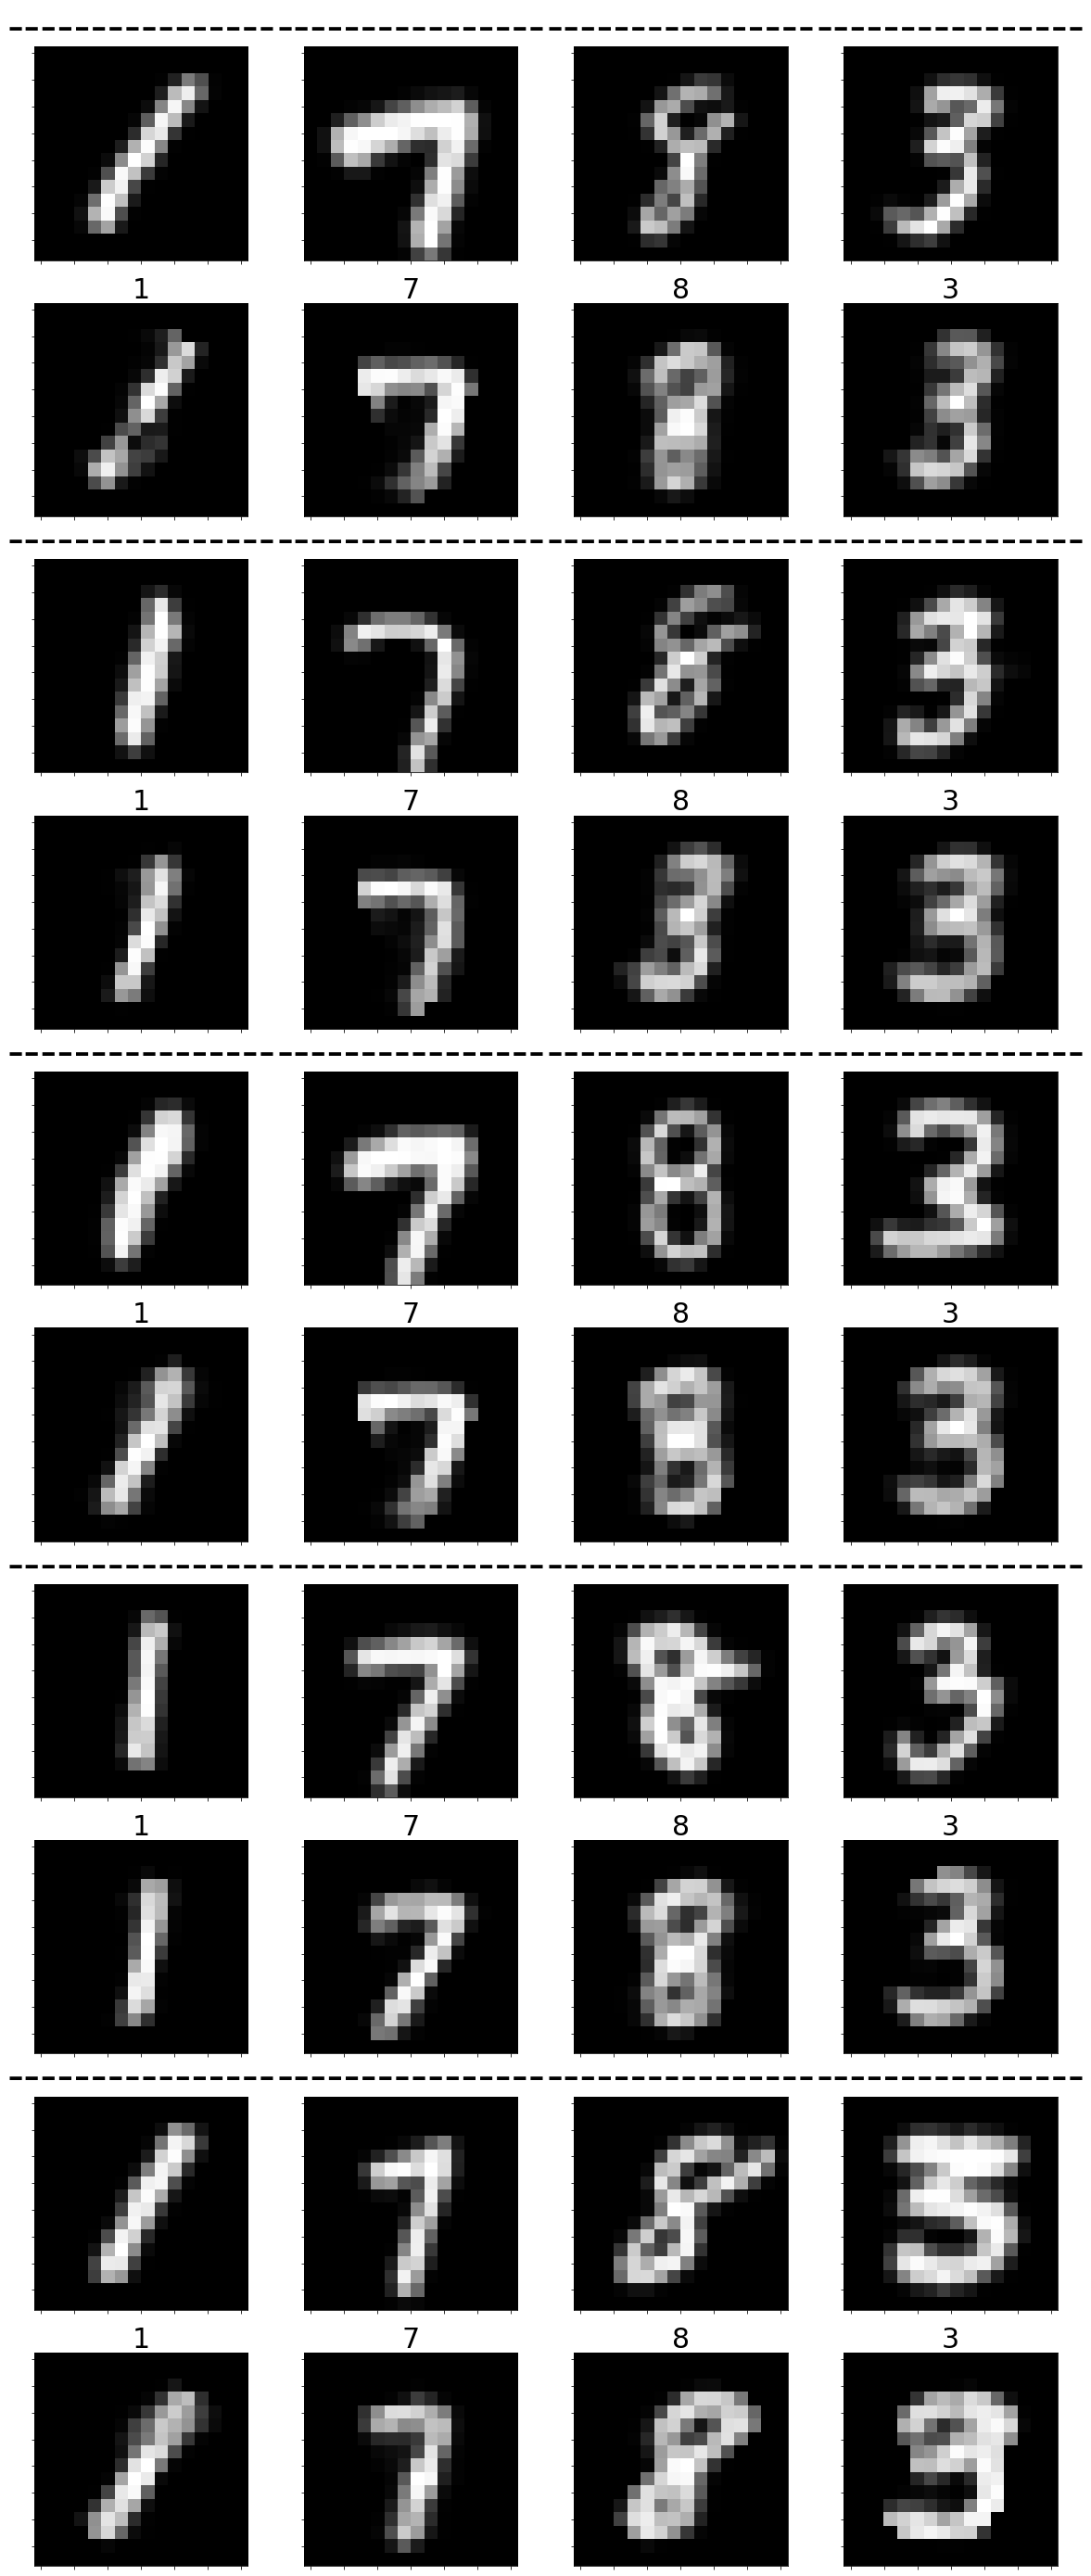

In [11]:
display_num = 5

height = display_num * 2
width = len(numbers)
fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")

for j in range(len(numbers)):
    x = inputs[labels==numbers[j]]
    y = outputs[labels==numbers[j]]
    for i in range(display_num):
        ax = fig.add_subplot(height, width, i*2*width+j+1)
        M = image_from_numpy(x[i:i+1])[0]
        ax.imshow(M)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title("----------------", fontsize=50)
        
        ax = fig.add_subplot(height, width, (i*2+1)*width+j+1)
        M = image_from_numpy(np.expand_dims(y[i:i+1], 0))[0]
        ax.imshow(M)
        ax.set_title(numbers[j], fontsize=30)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

### Latent codes
---
次に，潜在ベクトルについて考えてみましょう．

---
Next, let's think about the latent code.

---

#### Check the distribution
---
まずは分布を確認してみます．

---
Initially, let's take a look at the distribution.

---

##### 1d
---
一次元に分布をさせてみましょう．
縦軸はデータのインデックスなので無視して大丈夫です．

- *target_dims*: 可視化対象の次元番号のリスト

---

Let's make a one-dimensional distribution. The vertical axis is the index of the data so you can ignore it.

- *target_dims*: List of dimension index to visualize.

---

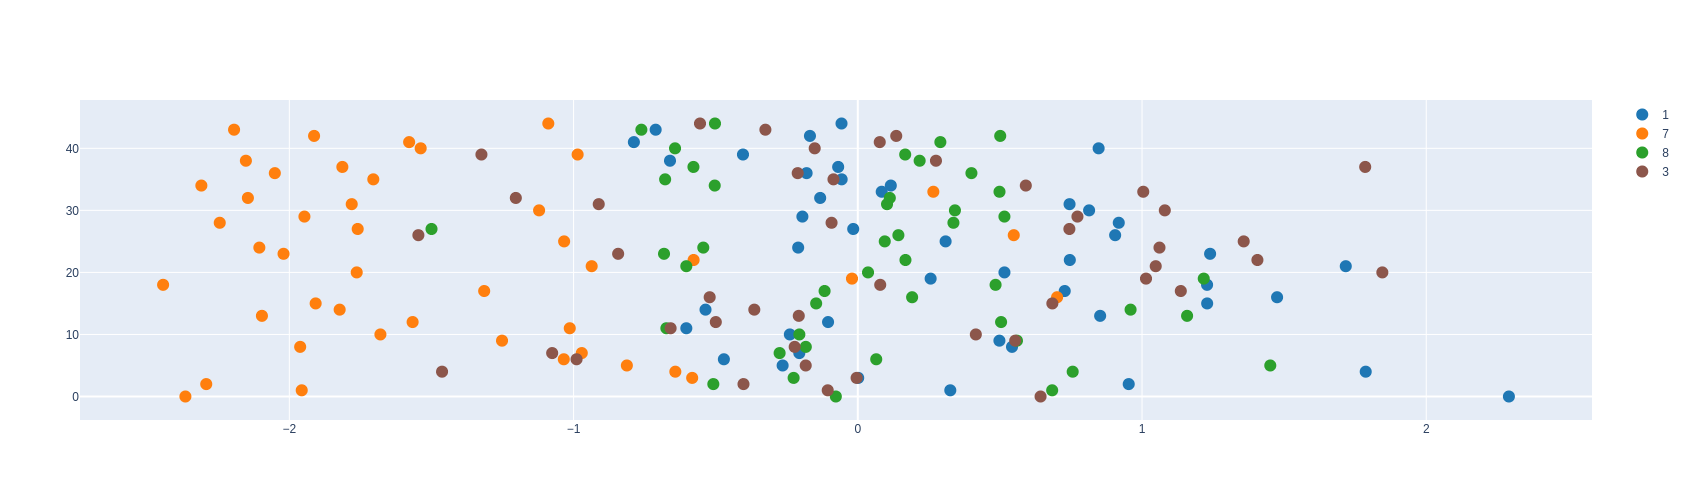

In [24]:
# ----- adjustable parameters ----- #
target_dims = [0]
# --------------------------------- #

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    trace.append(go.Scatter(x=_x, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=12, color=colors[i])))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

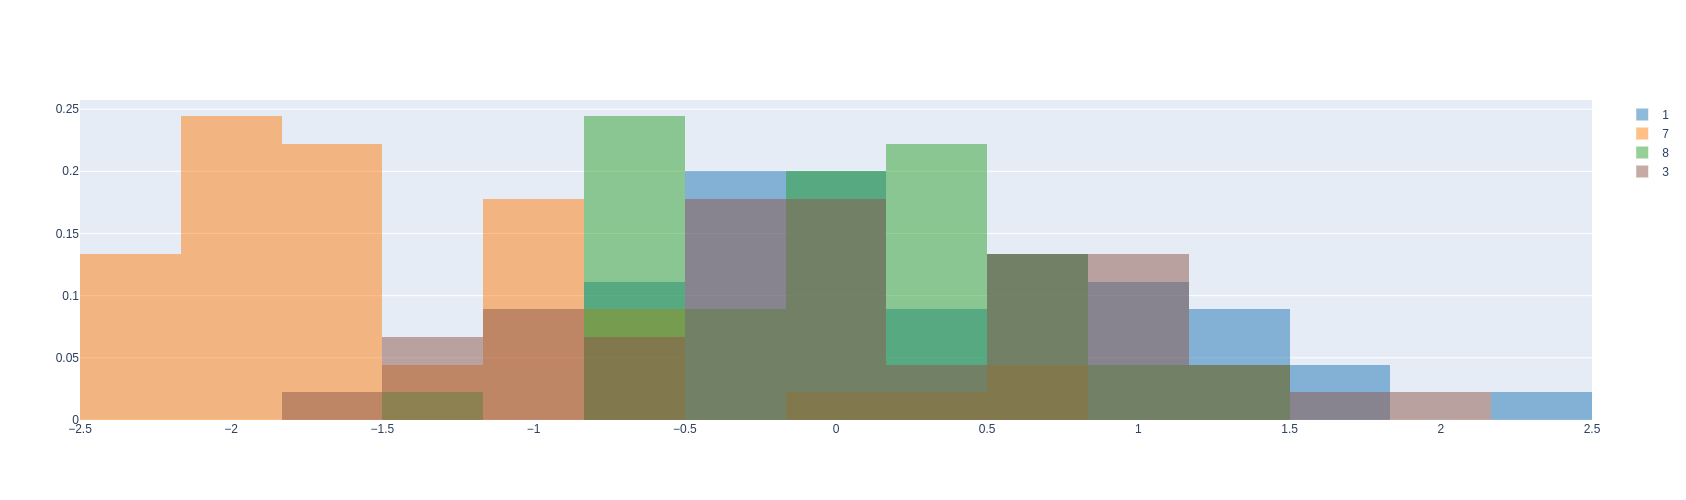

In [49]:
# ----- adjustable parameters ----- #
target_dims = [0]
# --------------------------------- #

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    trace.append(go.Histogram(x=_x, histnorm="probability", opacity=0.5, marker=dict(color=colors[i]),
                              xbins=dict(start=-2.5, end=2.5, size=5/15), name=f"{numbers[i]}"))
                              
layout = go.Layout(width=700, height=500, barmode="overlay") 
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
---
---
演習: これをみて，自分なりに考察してみてください．

Exercise: Take a look at this and think about it in your own way.

---

Answer:

---
---
---

##### 2d
---
二次元に分布をさせてみましょう．

---
Let's make a two-dimensional distribution.

---

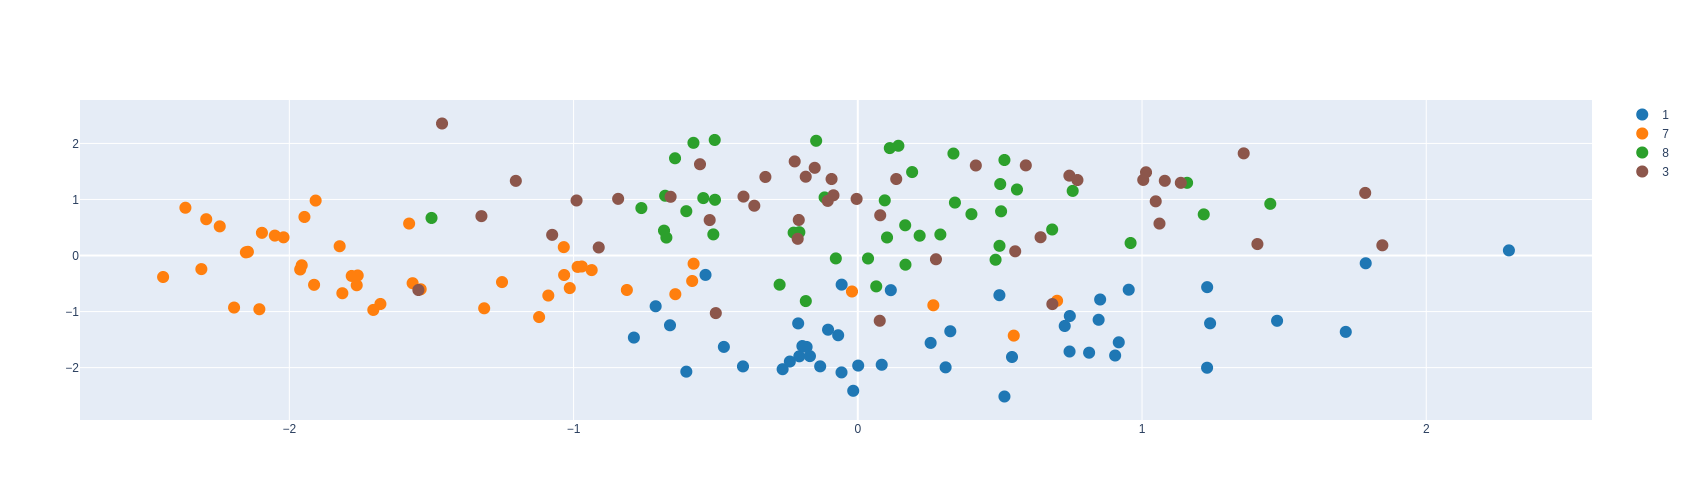

In [15]:
# ----- adjustable parameters ----- #
target_dims = [0, 1]
# --------------------------------- #

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    _y = m[:, target_dims[1]]
    trace.append(go.Scatter(x=_x, y=_y, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=12, color=colors[i])))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
---
---
演習: これをみて，自分なりに考察してみてください（前回の演習の違いを意識しながら）．

Exercise:  Take a look at and reflect on it in your own way (what are the differences from the previous exercise)

---

Answer:

---
---
---

##### 3d
---
三次元に分布をさせてみましょう．

---
Let's make a three-dimensional distribution.

---

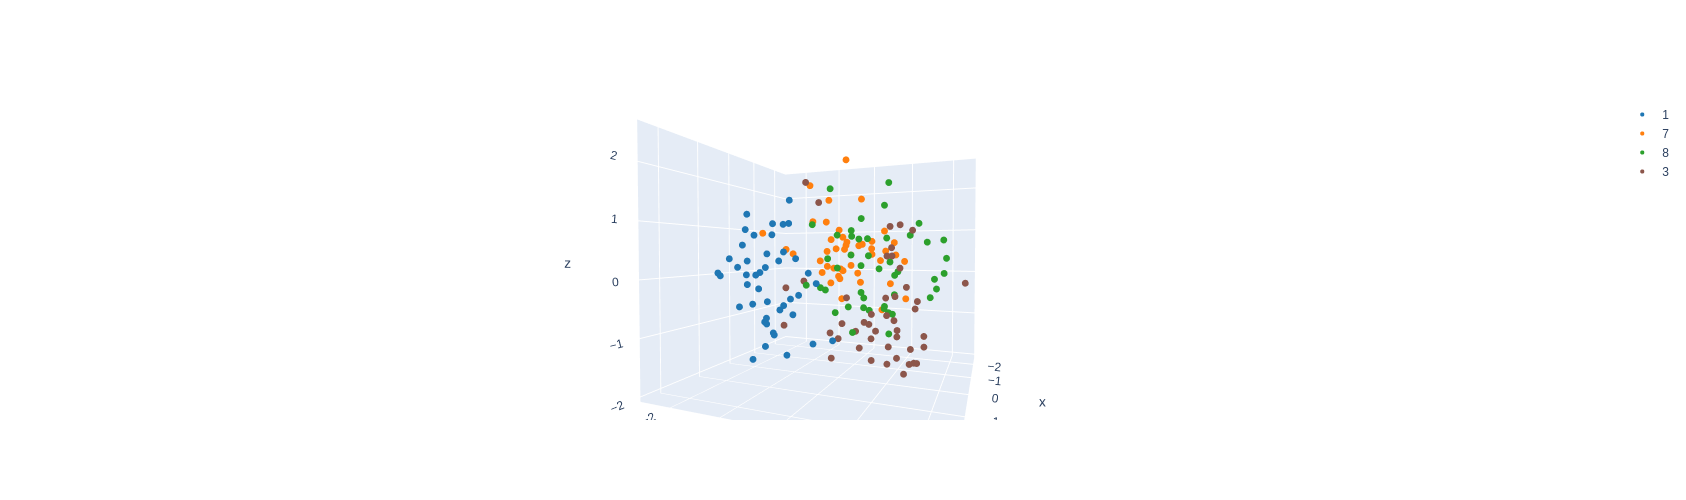

In [16]:
# ----- adjustable parameters ----- #
target_dims = [0, 1, 2]
# --------------------------------- #

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    _y = m[:, target_dims[1]]
    _z = m[:, target_dims[2]]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=4, color=colors[i])))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
---
---
演習: これをみて，自分なりに考察してみてください（前回の演習の違いを意識しながら）．

Exercise:  Take a look at and reflect on it in your own way (what are the differences from the previous exercise)

---

Answer:

---
---
---

#### Images alinghed in 2D
---
次にデコーダのみを用いて，潜在変数を徐々に変化させた場合の生成結果を見てみましょう．

- *target_dims*: 変化させる次元番号のリスト，二つだけ選んでください．
- *x_num*: 最初に選んだ次元において，最小値から最大値までにどれくらいの量の潜在ベクトルを定義するか
- *y_num*: 最後に選んだ次元において，最小値から最大値までにどれくらいの量の潜在ベクトルを定義するか

---

Next, let's look at the results generated by the decoder while gradually changing the latent variables.

- *target_dims*: List of dimension numbers to change; choose only two.
- *x_num*: How many latent vectors should be defined from the minimum to the maximum in the first dimension chosen.
- *y_num*: How many latent vectors from minimum to maximum should be defined in the last dimension chosen

---

In [28]:
# ----- adjustable parameters ----- #
target_dims = [0, 1] 
x_num = 8
y_num = 8
# --------------------------------- #

target_dims = np.array(target_dims)
fixed_dims = np.sort(np.array(list(set(list(range(z_dim)))-set(list(target_dims)))))
fixed_mean = np.mean(latents[:, fixed_dims], axis=0)

min_ = np.min(latents[:, target_dims], axis=0)
max_ = np.max(latents[:, target_dims], axis=0)
xax = np.linspace(min_[0], max_[0], num=x_num).reshape(1, -1)
yax = np.linspace(min_[1], max_[1], num=y_num).reshape(-1, 1)

target_latents = np.ones((x_num*y_num, z_dim))
target_latents[:, target_dims[0]] = np.tile(xax, reps=(x_num, 1)).reshape(-1)
target_latents[:, target_dims[1]] = np.tile(yax, reps=(1, y_num)).reshape(-1)
for i in range(len(fixed_dims)):
    target_latents[:, fixed_dims[i]] = target_latents[:, fixed_dims[i]] * fixed_mean[i]
    
z = torch.tensor(target_latents, dtype=net.state_dict()["encoder.1.weight"].dtype)
y = net._decoder(z)
images = image_from_output(y.unsqueeze(1))

---
以下のように潜在ベクトルを変化させます．
変化させない次元の値は，その次元での平均値を設定してます．

---
Change the latent vector as follows. The value of the dimension that is not changed is set to the average value in that dimension.

---

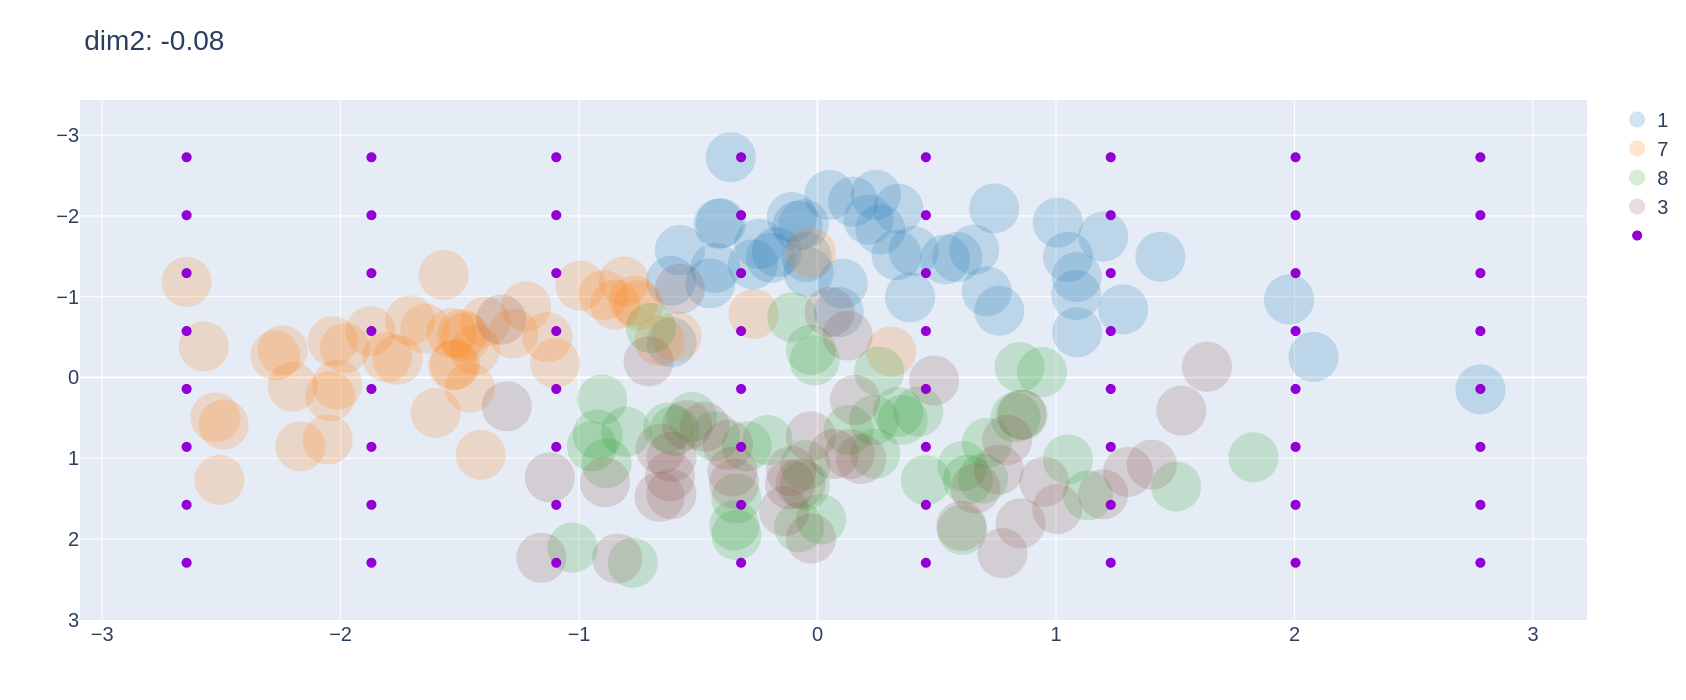

In [104]:
# latent codes of test dataset 
trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    _y = m[:, target_dims[1]]
    trace.append(go.Scatter(x=_x, y=_y, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=50, opacity=0.2, color=colors[i])))
    
# customized latent codes
m = latents[labels==numbers[i]]
x = target_latents[:,target_dims[0]]
y = target_latents[:,target_dims[1]]
trace.append(go.Scatter(x=x, y=y, mode="markers", name=f"",
                          marker = dict(size=10, color="DarkViolet")))

for i, dim in enumerate(fixed_dims):
    t = f"dim{dim}: {str(np.round(fixed_mean[i], 2))}"
    if i == 0:
        title = t
    else:
        title = title + f", {t}"
layout = go.Layout(yaxis=dict(autorange="reversed"), width=700, height=700, title=title, font=dict(size=20))
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
これが生成結果になります．

---
This is the result of generation.

---

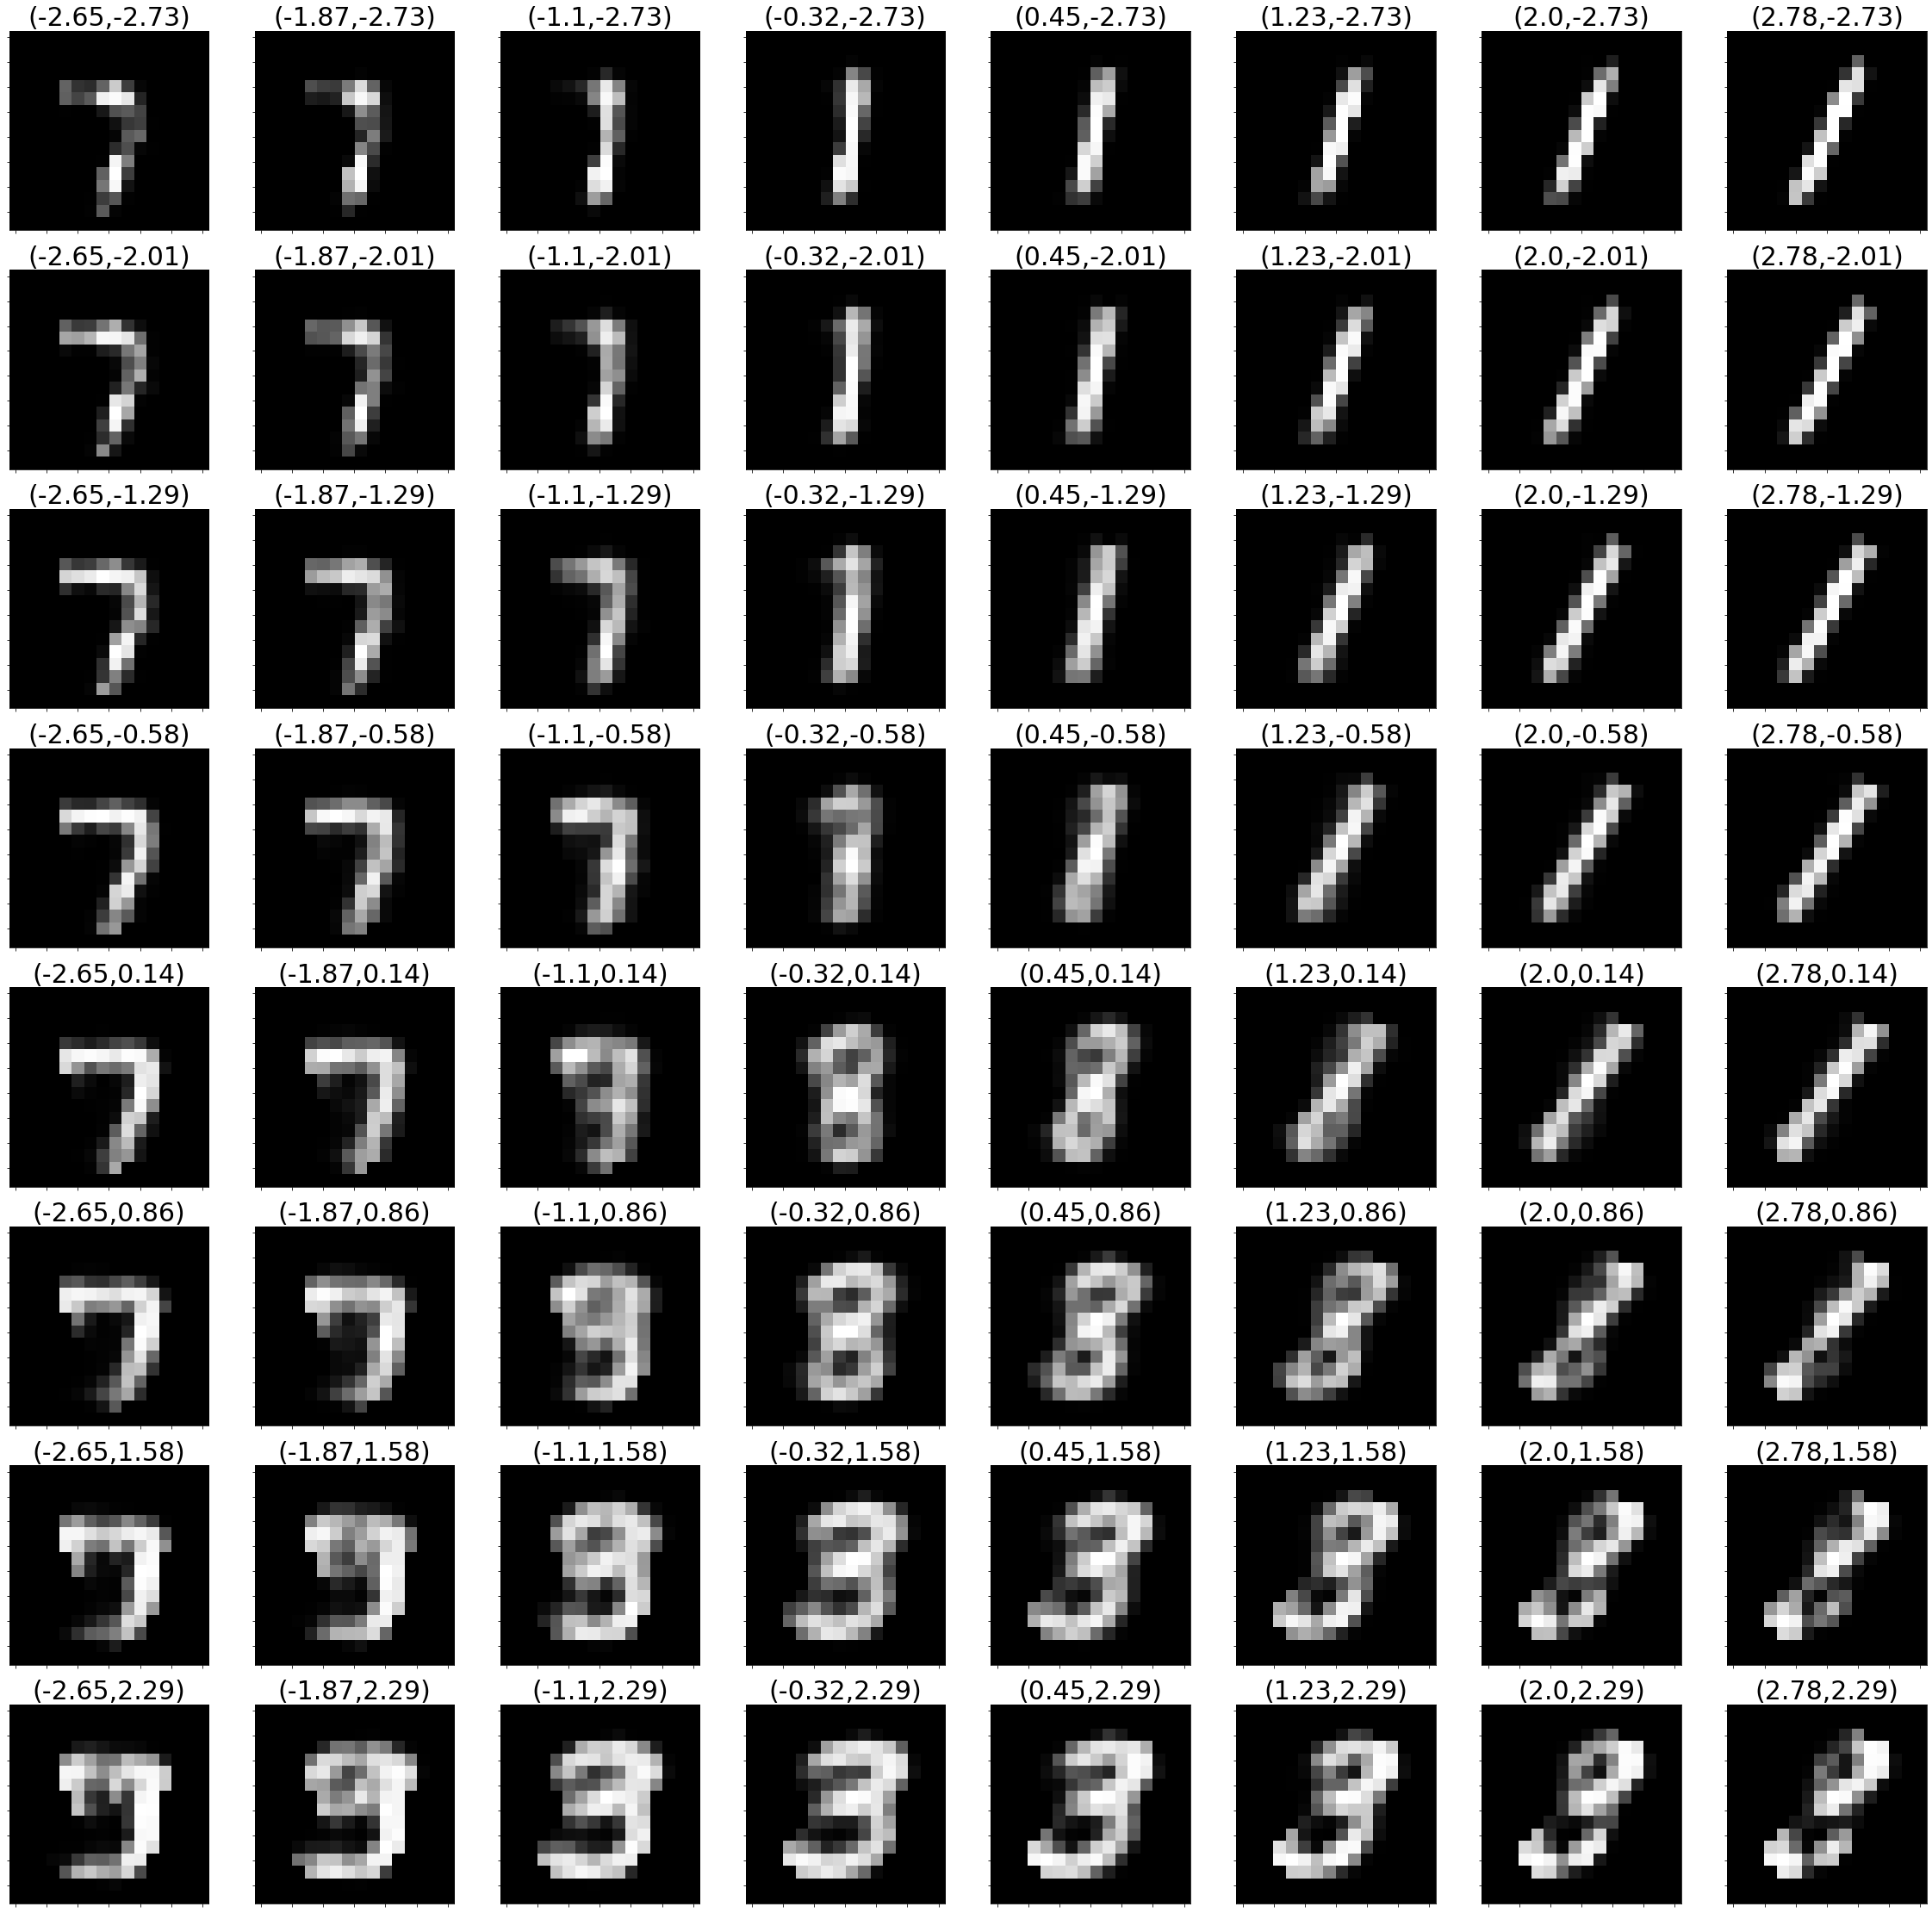

In [30]:
height = x_num
width = y_num
fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")

for j in range(height*width):
    ax = fig.add_subplot(height, width, j+1)
    M = images[j]
    ax.imshow(M)
    x_ = str(np.round(target_latents[:,target_dims[0]][j], 2))
    y_ = str(np.round(target_latents[:,target_dims[1]][j], 2))
    ax.set_title(f"({x_},{y_})", fontsize=30)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

# Applications
---
1. 特徴量抽出（データ圧縮）

この例では主にEncoderだけを用いる．
一番オーソドックスな使い方として，特徴量抽出があります．
今までの授業でもわかるとおり，VAEの潜在空間では，視覚的に類似した数字の潜在ベクトルが近くなっている．
これにより，この潜在ベクトルを，入力データの特徴量と表すことが可能になる．
潜在ベクトルの次元よりも入力データの次元の方が小さいことが主なので，データ圧縮と捉えることもできる．

2. ノイズ除去

ここでは，EncoderとDecoderの両方のモデルを用いる．
Decoderの出力は必ずしも入力データと同一になるのではなく，概要を捉えたデータになる．
この前提を用いたのがノイズ除去である．
入力データに多少のノイズがあっても，Encoderがそれを無視して圧縮することで，ノイズが減ったデータをDecoderが出力する．

<img src="./../data/images/denoising.png" width="900">

＜直感的理解＞
Decoderは限られた次元数でデータセットを表現しないと行けないことから，それぞれのデータセットの"平均"捉えた画像を出力する．
よって，ノイズが訓練データセットのすべてのデータに適用されていない限りは，それを無視するようになっている．

3. 異常検知（授業の課題）

この応用については今回の課題で扱うので，詳しくは`notebooks/Assignment.ipynb`で学んでください．

---

1. Feature extraction (data compression)

In this example, only Encoder is used. The most common usage is feature extraction. As you can see in the lessons so far, in the VAE latent space, the latent vectors of visually similar numbers are close to each other. This allows the latent vector to be used as a feature of the input data. Since, in most cases, the dimension of the input data is smaller than the dimension of the latent vectors, it can be regarded as data compression.

2. Noise Removal

In this section, we use both Encoder and Decoder models. The output of the decoder is not necessarily the same as the input data, but rather a summary of the data. This assumption is used in denoising. Even if there is some noise in the input data, the encoder will ignore it and compress the data, and the decoder will output data with less noise.

<img src="./../data/images/denoising.png" width="900">

\<Intuitive Understanding\> Since the decoder has to represent the datasets in a limited number of dimensions, it outputs the "average" image of each dataset. Therefore, unless noise is applied to all the data in the training dataset, it will be ignored.

3. Anomaly detection (class assignment)

This application is covered in this week's assignment, so please visit `notebooks/Assignment.ipynb` to learn more.

---

# Related Models and Recent Research
---
1. The Balancing Issue

VAEの損失関数における，再構築損失とKL divergence loss（潜在空間を制御する損失関数）のバランスを決定する研究．

2. Variable Collapse Phenomenon

Decoderが，潜在ベクトルを適切に使用しないことを解決するための研究．

3. 様々な構造
- Two-Stage VAE
- Regularized VAE (RAE)
- Hierarchical Variational Autoencoder

---

1. The Balancing Issue

A study to determine the balance between reconstruction loss and KL divergence loss (loss function controlling the latent space) in the loss function of VAE.

2. Variable Collapse Phenomenon

A study to solve the problem that Decoder does not use latent vectors properly.

3. Various structures
- Two-Stage VAE
- Regularized VAE (RAE)
- Hierarchical Variational Autoencoder

---